In [10]:
%matplotlib inline

import numpy.random as npr
import math
import matplotlib.pyplot as plt

from tqdm import tqdm

In [11]:
import sys
sys.path.append("/home/hofmann/nngame/package/src/rlbase/")
from importlib import reload

import env_bandit
import agent_greedy
import agent_gradient
import misc
from rl_glue import RLGlue
reload(env_bandit)
reload(agent_greedy)
reload(agent_gradient)
reload(misc)

<module 'misc' from '/home/hofmann/nngame/package/src/rlbase/misc.py'>

# Figure 2.2
Average performance of $\epsilon$-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.

In [ ]:
k = 10

N_timesteps = 1000
N_bandits = 2000

arr_eps = [0,0.01,0.1]

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in arr_eps}
optimal_actions = {i:[0]*N_timesteps for i in arr_eps}
for bandit in tqdm(range(N_bandits)):
  for eps in arr_eps:

    agent = agent_greedy.EpsGreedyAgent
    agent_info = {"num_actions": k, "epsilon": eps}    
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[eps][t] += reward / N_bandits
      optimal_actions[eps][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for e in arr_eps:
  plt.plot(results[e])
plt.legend(["eps="+str(e) for e in arr_eps])

plt.subplot(2,1,2)
for e in arr_eps:
  plt.plot(optimal_actions[e])
plt.legend(["eps="+str(e) for e in arr_eps])

plt.show()

# Exercise 2.5
Demonstrate the difficulties that sample-average methods have for nonstationary problems.

In [ ]:
k = 10

N_timesteps = 10000
N_bandits = 1000

env = env_bandit.BanditEnvironment    
env_info = {"N": k, "random":True}

stepsizes = ["SampleAverage", "ConstantStepsize"]

results         = {i:[0]*N_timesteps for i in stepsizes}
optimal_actions = {i:[0]*N_timesteps for i in stepsizes}
for bandit in tqdm(range(N_bandits)):
  for s in stepsizes:
    agent = agent_greedy.EpsGreedyAgent
    if s == "SampleAverage":
        agent_info = {"num_actions": k, "epsilon": 0.1}    
    else:
        agent_info = {"num_actions": k, "epsilon": 0.1, "step_size": 0.1}    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    for t in range(N_timesteps):
      best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
      reward, _, action, _ = rl_glue.rl_step()
      results[s][t] += reward / N_bandits
      optimal_actions[s][t] += (action==best_action) / N_bandits   
        
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for e in stepsizes:
  plt.plot(results[e])
plt.legend(stepsizes)

plt.subplot(2,1,2)
for e in stepsizes:
  plt.plot(optimal_actions[e])
plt.legend(stepsizes)

plt.show()

# Figure 2.3
The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods use a constant step-size parameter, $\alpha=0.1$.

In [ ]:
k = 10

N_timesteps = 1000
N_bandits = 1000

agent_info_1 = {"num_actions": k, "epsilon": 0.1, "step_size":0.1, "initial_value": 0}
agent_info_2 = {"num_actions": k, "epsilon": 0  , "step_size":0.1, "initial_value": 5}

agent_infos = {"Q="+str(e["initial_value"])+",eps="+str(e["step_size"]):e for e in [agent_info_1, agent_info_2]}

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for k,agent_info in agent_infos.items():

    agent = agent_greedy.EpsGreedyAgent
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[k][t] += reward / N_bandits
      optimal_actions[k][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for agent_info in agent_infos:
  plt.plot(results[agent_info])
plt.legend(agent_infos.keys())

plt.subplot(2,1,2)
for agent_info in agent_infos:
  plt.plot(optimal_actions[agent_info])
plt.legend(agent_infos.keys())

plt.show()

# Figure 2.4
Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than $\epsilon$-greedy action selection, except in the first $k$ steps, when it selects randomly among the as-yet-untried actions.

In [ ]:
k = 10

N_timesteps = 1000
N_bandits = 1000

agent_info_1 = {"num_actions": k, "epsilon": 0.1}
agent_info_2 = {"num_actions": k, "ucb_c":2}

agent_infos = dict(zip(["eps=0.1","UCB c=2"],[agent_info_1, agent_info_2]))

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for k,agent_info in agent_infos.items():

    agent = agent_greedy.EpsGreedyAgent
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[k][t] += reward / N_bandits
      optimal_actions[k][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for agent_info in agent_infos:
  plt.plot(results[agent_info])
plt.legend(agent_infos.keys())

plt.subplot(2,1,2)
for agent_info in agent_infos:
  plt.plot(optimal_actions[agent_info])
plt.legend(agent_infos.keys())

plt.show()

# Figure 2.5
Average performance of the gradient bandit algorithm with and without a reward baseline on the 10-armed testbed when the $q_*(a)$ are chosen to be near $+4$ rather than near zero.

100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


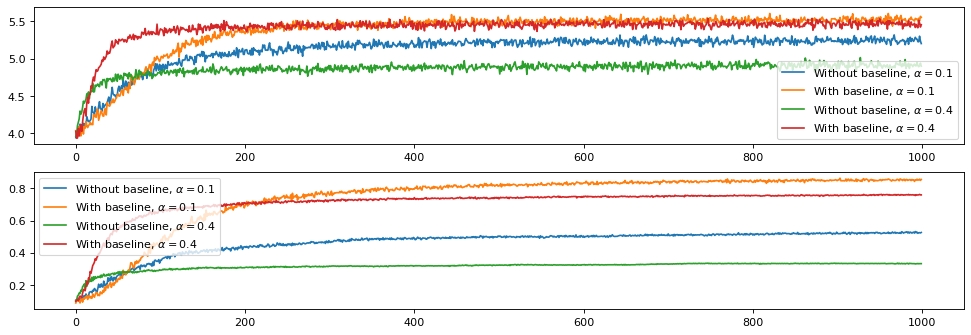

In [12]:
k = 10

N_timesteps = 1000
N_bandits = 1000

agent_info_1 = {"num_actions": k, "step_size": 0.1, "baseline": False}
agent_info_2 = {"num_actions": k, "step_size": 0.1, "baseline": True}
agent_info_3 = {"num_actions": k, "step_size": 0.4, "baseline": False}
agent_info_4 = {"num_actions": k, "step_size": 0.4, "baseline": True}

agent_infos = dict(zip([r"Without baseline, $\alpha=0.1$",r"With baseline, $\alpha=0.1$",
                       r"Without baseline, $\alpha=0.4$",r"With baseline, $\alpha=0.4$"],
                       [agent_info_1, agent_info_2,agent_info_3, agent_info_4]))

env = env_bandit.BanditEnvironment    
env_info = {"N": k, "offset": 4}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for k,agent_info in agent_infos.items():

    agent = agent_gradient.GradientAgent
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[k][t] += reward / N_bandits
      optimal_actions[k][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for agent_info in agent_infos:
  plt.plot(results[agent_info])
plt.legend(agent_infos.keys())

plt.subplot(2,1,2)
for agent_info in agent_infos:
  plt.plot(optimal_actions[agent_info])
plt.legend(agent_infos.keys())

plt.show()

# Figure 2.6
A parameter study of the various bandit algorithms presented in this chapter. Each point is the average reward obtained over 1000 steps with a particular algorithm at a particular setting of its parameter

In [4]:
import numpy as np
k = 10

N_timesteps = 1000
N_bandits = 100

agent_infos = {}
#for eps in np.power(2.,np.arange(-7,-1,.5)):
#    key = ("$\epsilon$-greedy",eps)
#    value = {"num_actions": k,"epsilon": eps}
#    agent_infos[key] = value
for ucb_c in np.power(2.,np.arange(-4,3,.5)):
    key = ("UCB",ucb_c)
    value = {"epsilon": 0, "num_actions": k,"ucb_c": ucb_c}
    agent_infos[key] = value
#for val in np.power(2.,np.arange(-2,3,.5)):
#    key = ("Optimistic",val)
#    value = {"epsilon": 0, "num_actions": k,"initial_value": val,"step_size":0.1}
#    agent_infos[key] = value
#for alpha in np.power(2.,np.arange(-5,3,.5)):
#    key = ("Gradient",alpha)
#    value = {"num_actions": k,"step_size": alpha}
#    agent_infos[key] = value
    
env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:0 for i in agent_infos}
optimal_actions = {i:0 for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for key,agent_info in agent_infos.items():
    if key[0]=="Gradient":
        agent = agent_gradient.GradientAgent
    else:
        agent = agent_greedy.EpsGreedyAgent    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    
    for t in range(N_timesteps):
      reward, _, _, _ = rl_glue.rl_step()
      results[key] += reward

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


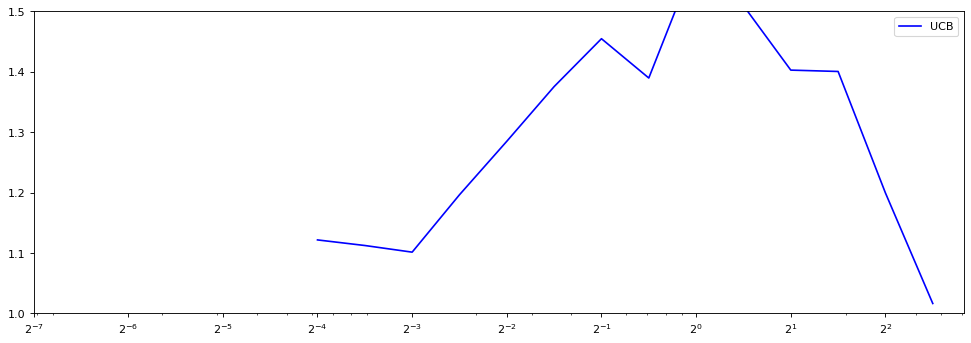

In [6]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

values_algo = [a for (a,b) in results.keys()]
values_x    = [b for (a,b) in results.keys()]
values_y    = [v/bandit/N_timesteps for v in results.values()]
df = pd.DataFrame({"x":values_x,"y":values_y,"algo":values_algo})

cols = {"$\epsilon$-greedy":"r","UCB":"b","Optimistic":"k","Gradient":"g"}
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
for a in list(set(df.algo)):
    d = df[df["algo"]==a]
    plt.semilogx(d.x,d.y,cols[a])
plt.legend(list(set(df.algo)))

exps = np.arange(-7,3)
xticks = np.power(2.,exps)
labels = [r"$2^{"+str(e)+"}$" for e in exps]

plt.xticks(xticks,labels)
plt.ylim(1,1.5)
plt.show()